In [6]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from collections import Counter
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional


warnings.filterwarnings('ignore')

In [7]:
a = pd.read_csv("../data/processed/df_validation_rolled.csv")
a['mask_id'].nunique()

685

In [17]:
simulation_df = pd.read_csv("../reports/metrics/simulation_periods.csv")
drift_df = pd.read_csv("../reports/metrics/schedule_drift_analysis.csv")

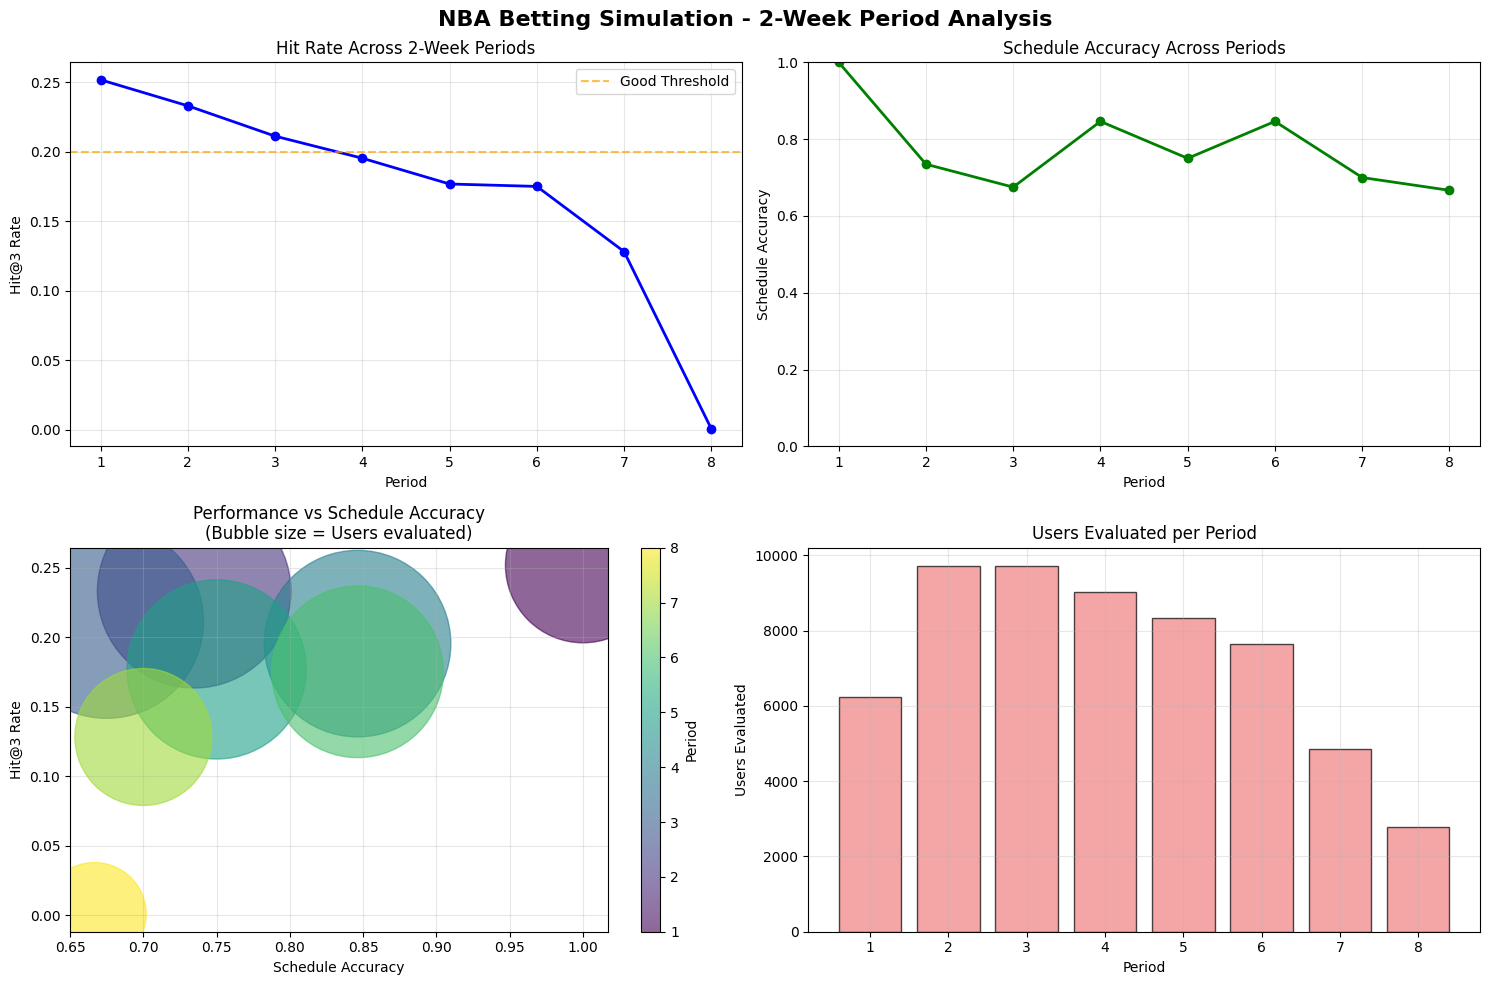

In [18]:
# Cell 2: Period-by-period performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('NBA Betting Simulation - 2-Week Period Analysis', fontsize=16, fontweight='bold')

# 1. Hit rate over time
axes[0, 0].plot(simulation_df['period'], simulation_df['hit_rate'], 'o-', color='blue', linewidth=2)
axes[0, 0].set_xlabel('Period')
axes[0, 0].set_ylabel('Hit@3 Rate')
axes[0, 0].set_title('Hit Rate Across 2-Week Periods')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(0.2, color='orange', linestyle='--', alpha=0.7, label='Good Threshold')
axes[0, 0].legend()

# 2. Schedule accuracy over time
axes[0, 1].plot(simulation_df['period'], simulation_df['schedule_accuracy'], 'o-', color='green', linewidth=2)
axes[0, 1].set_xlabel('Period')
axes[0, 1].set_ylabel('Schedule Accuracy')
axes[0, 1].set_title('Schedule Accuracy Across Periods')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 1)

# 3. Hit rate vs Schedule accuracy scatter
scatter = axes[1, 0].scatter(simulation_df['schedule_accuracy'], simulation_df['hit_rate'], 
                            s=simulation_df['users_evaluated']*2, alpha=0.6, c=simulation_df['period'], cmap='viridis')
axes[1, 0].set_xlabel('Schedule Accuracy')
axes[1, 0].set_ylabel('Hit@3 Rate')
axes[1, 0].set_title('Performance vs Schedule Accuracy\n(Bubble size = Users evaluated)')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Period')

# 4. Users evaluated per period
bars = axes[1, 1].bar(simulation_df['period'], simulation_df['users_evaluated'], 
                      color='lightcoral', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Period')
axes[1, 1].set_ylabel('Users Evaluated')
axes[1, 1].set_title('Users Evaluated per Period')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== SCHEDULE DRIFT ANALYSIS ===
Average games per period (pre-season): 24.2
Average games per period (actual): 19.0
Average games cancelled/moved: 5.2


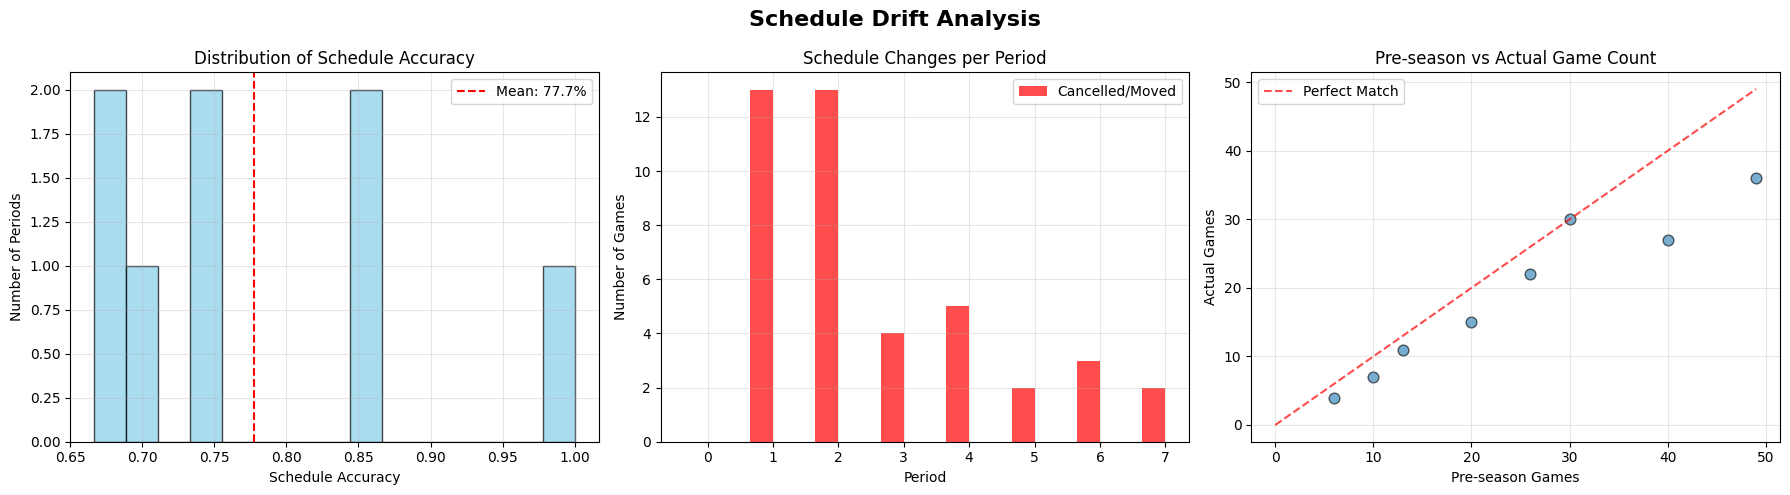

In [21]:
# Cell 3: Schedule drift analysis
print("=== SCHEDULE DRIFT ANALYSIS ===")
print(f"Average games per period (pre-season): {drift_df['total_preseason_games'].mean():.1f}")
print(f"Average games per period (actual): {drift_df['total_actual_games'].mean():.1f}")
print(f"Average games cancelled/moved: {drift_df['games_cancelled_or_moved'].mean():.1f}")

# Drift visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Schedule Drift Analysis', fontsize=16, fontweight='bold')

# 1. Schedule accuracy distribution
axes[0].hist(drift_df['schedule_accuracy'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Schedule Accuracy')
axes[0].set_ylabel('Number of Periods')
axes[0].set_title('Distribution of Schedule Accuracy')
axes[0].axvline(drift_df['schedule_accuracy'].mean(), color='red', linestyle='--', 
                label=f'Mean: {drift_df["schedule_accuracy"].mean():.1%}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Games cancelled vs added
x = range(len(drift_df))
width = 0.35
axes[1].bar([i - width/2 for i in x], drift_df['games_cancelled_or_moved'], 
           width, label='Cancelled/Moved', color='red', alpha=0.7)
axes[1].set_xlabel('Period')
axes[1].set_ylabel('Number of Games')
axes[1].set_title('Schedule Changes per Period')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Total games comparison
axes[2].scatter(drift_df['total_preseason_games'], drift_df['total_actual_games'], 
               alpha=0.6, s=60, edgecolor='black')
axes[2].plot([0, drift_df['total_preseason_games'].max()], 
             [0, drift_df['total_preseason_games'].max()], 
             'r--', alpha=0.7, label='Perfect Match')
axes[2].set_xlabel('Pre-season Games')
axes[2].set_ylabel('Actual Games')
axes[2].set_title('Pre-season vs Actual Game Count')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== PERFORMANCE CORRELATIONS ===


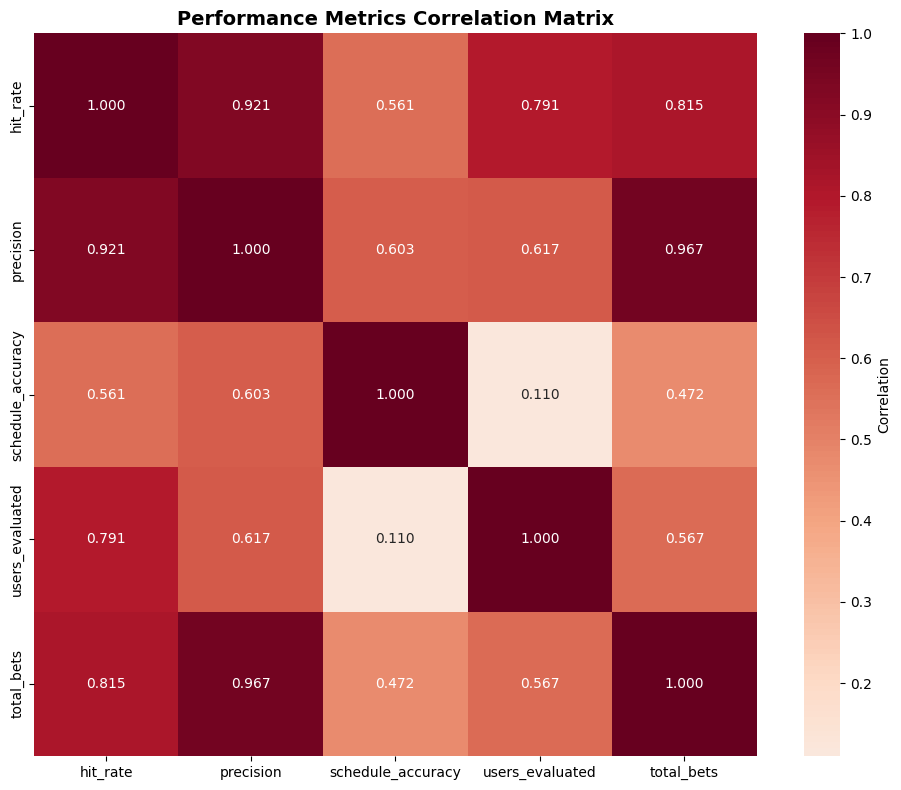


Key Insights:
Hit Rate vs Schedule Accuracy correlation: 0.561
Hit Rate vs Users Evaluated correlation: 0.791


In [22]:
# Cell 4: Performance correlation analysis
print("=== PERFORMANCE CORRELATIONS ===")
correlation_data = simulation_df[['hit_rate', 'precision', 'schedule_accuracy', 'users_evaluated', 'total_bets']]
corr_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})
plt.title('Performance Metrics Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"Hit Rate vs Schedule Accuracy correlation: {corr_matrix.loc['hit_rate', 'schedule_accuracy']:.3f}")
print(f"Hit Rate vs Users Evaluated correlation: {corr_matrix.loc['hit_rate', 'users_evaluated']:.3f}")

In [23]:
# Cell 5: Recommendations and insights
print("=== SIMULATION INSIGHTS & RECOMMENDATIONS ===")

# Performance categorization
excellent_periods = (simulation_df['hit_rate'] >= 0.3).sum()
good_periods = ((simulation_df['hit_rate'] >= 0.15) & (simulation_df['hit_rate'] < 0.3)).sum()
poor_periods = (simulation_df['hit_rate'] < 0.15).sum()

print(f"\nPeriod Performance Distribution:")
print(f"Excellent periods (≥0.3 Hit@3): {excellent_periods} ({excellent_periods/len(simulation_df)*100:.1f}%)")
print(f"Good periods (0.15-0.3 Hit@3): {good_periods} ({good_periods/len(simulation_df)*100:.1f}%)")
print(f"Poor periods (<0.15 Hit@3): {poor_periods} ({poor_periods/len(simulation_df)*100:.1f}%)")

# Schedule impact analysis
high_accuracy = simulation_df[simulation_df['schedule_accuracy'] >= 0.8]
low_accuracy = simulation_df[simulation_df['schedule_accuracy'] < 0.8]

if len(high_accuracy) > 0 and len(low_accuracy) > 0:
    print(f"\nSchedule Impact Analysis:")
    print(f"High accuracy periods (≥80%): Hit@3 = {high_accuracy['hit_rate'].mean():.3f}")
    print(f"Low accuracy periods (<80%): Hit@3 = {low_accuracy['hit_rate'].mean():.3f}")
    print(f"Performance difference: {high_accuracy['hit_rate'].mean() - low_accuracy['hit_rate'].mean():.3f}")

print(f"\nRecommendations:")
print("1. Focus on improving model performance during low schedule accuracy periods")
print("2. Consider incorporating real-time schedule updates into the recommendation system")
print("3. Develop fallback strategies for periods with high schedule drift")
print("4. Monitor user engagement patterns during different types of periods")

# Best and worst performing periods
best_period = simulation_df.loc[simulation_df['hit_rate'].idxmax()]
worst_period = simulation_df.loc[simulation_df['hit_rate'].idxmin()]

print(f"\nBest Period: {best_period['start_date']} to {best_period['end_date']}")
print(f"  Hit@3: {best_period['hit_rate']:.3f}, Schedule Accuracy: {best_period['schedule_accuracy']:.1%}")

print(f"\nWorst Period: {worst_period['start_date']} to {worst_period['end_date']}")
print(f"  Hit@3: {worst_period['hit_rate']:.3f}, Schedule Accuracy: {worst_period['schedule_accuracy']:.1%}")

=== SIMULATION INSIGHTS & RECOMMENDATIONS ===

Period Performance Distribution:
Excellent periods (≥0.3 Hit@3): 0 (0.0%)
Good periods (0.15-0.3 Hit@3): 6 (75.0%)
Poor periods (<0.15 Hit@3): 2 (25.0%)

Schedule Impact Analysis:
High accuracy periods (≥80%): Hit@3 = 0.207
Low accuracy periods (<80%): Hit@3 = 0.150
Performance difference: 0.057

Recommendations:
1. Focus on improving model performance during low schedule accuracy periods
2. Consider incorporating real-time schedule updates into the recommendation system
3. Develop fallback strategies for periods with high schedule drift
4. Monitor user engagement patterns during different types of periods

Best Period: 2025-04-14 to 2025-04-27
  Hit@3: 0.252, Schedule Accuracy: 100.0%

Worst Period: 2025-06-02 to 2025-06-15
  Hit@3: 0.001, Schedule Accuracy: 66.7%


In [24]:
# Cell 6: Detailed period breakdown table
print("=== DETAILED PERIOD BREAKDOWN ===")
display_df = simulation_df[['period', 'start_date', 'end_date', 'hit_rate', 'precision', 
                           'schedule_accuracy', 'users_evaluated', 'total_bets']].copy()
display_df['hit_rate'] = display_df['hit_rate'].round(3)
display_df['precision'] = display_df['precision'].round(3)
display_df['schedule_accuracy'] = display_df['schedule_accuracy'].round(3)

print(display_df.to_string(index=False))

=== DETAILED PERIOD BREAKDOWN ===
 period start_date   end_date  hit_rate  precision  schedule_accuracy  users_evaluated  total_bets
      1 2025-04-14 2025-04-27     0.252      0.162              1.000             6246        5569
      2 2025-04-21 2025-05-04     0.233      0.134              0.735             9716        5354
      3 2025-04-28 2025-05-11     0.211      0.105              0.675             9716        3954
      4 2025-05-05 2025-05-18     0.195      0.091              0.846             9022        3097
      5 2025-05-12 2025-05-25     0.177      0.068              0.750             8328        2122
      6 2025-05-19 2025-06-01     0.175      0.058              0.846             7634        1661
      7 2025-05-26 2025-06-08     0.128      0.043              0.700             4858        1211
      8 2025-06-02 2025-06-15     0.001      0.000              0.667             2776         889
